# Terraform

## Чем поможет Terraform? Так ли он нужен?

1. Предоставление инфраструктуры и решение долгих рутинных задач
2. Снижение человеческого фактора
3. Обновление
4. Стандартизация
5. Доступность
6. Работа в команде

## Что такое Terraform? Аналог Pulumi

![](Terraform_Logo.svg.png)

**Terraform** - это программный инструмент для создания инфраструктуры в облаке при помощи кода и автоматизиции её развёртывания, модификации и удалениея, так называемый IaC (Infrastructure as code). 

Он поддерживает множество провайдеров — таких, как AWS, Google Cloud, Azure, Yandex Cloud, VK Cloud и других.

[Документация Terraform](https://developer.hashicorp.com/terraform/docs)

## Как установить Terraform

Для того, чтобы установить terraform перейдите во вкладку `Install` на сайте [документации](https://developer.hashicorp.com/terraform/install#windows), выберите вашу ОС и следуйте инструкциям!

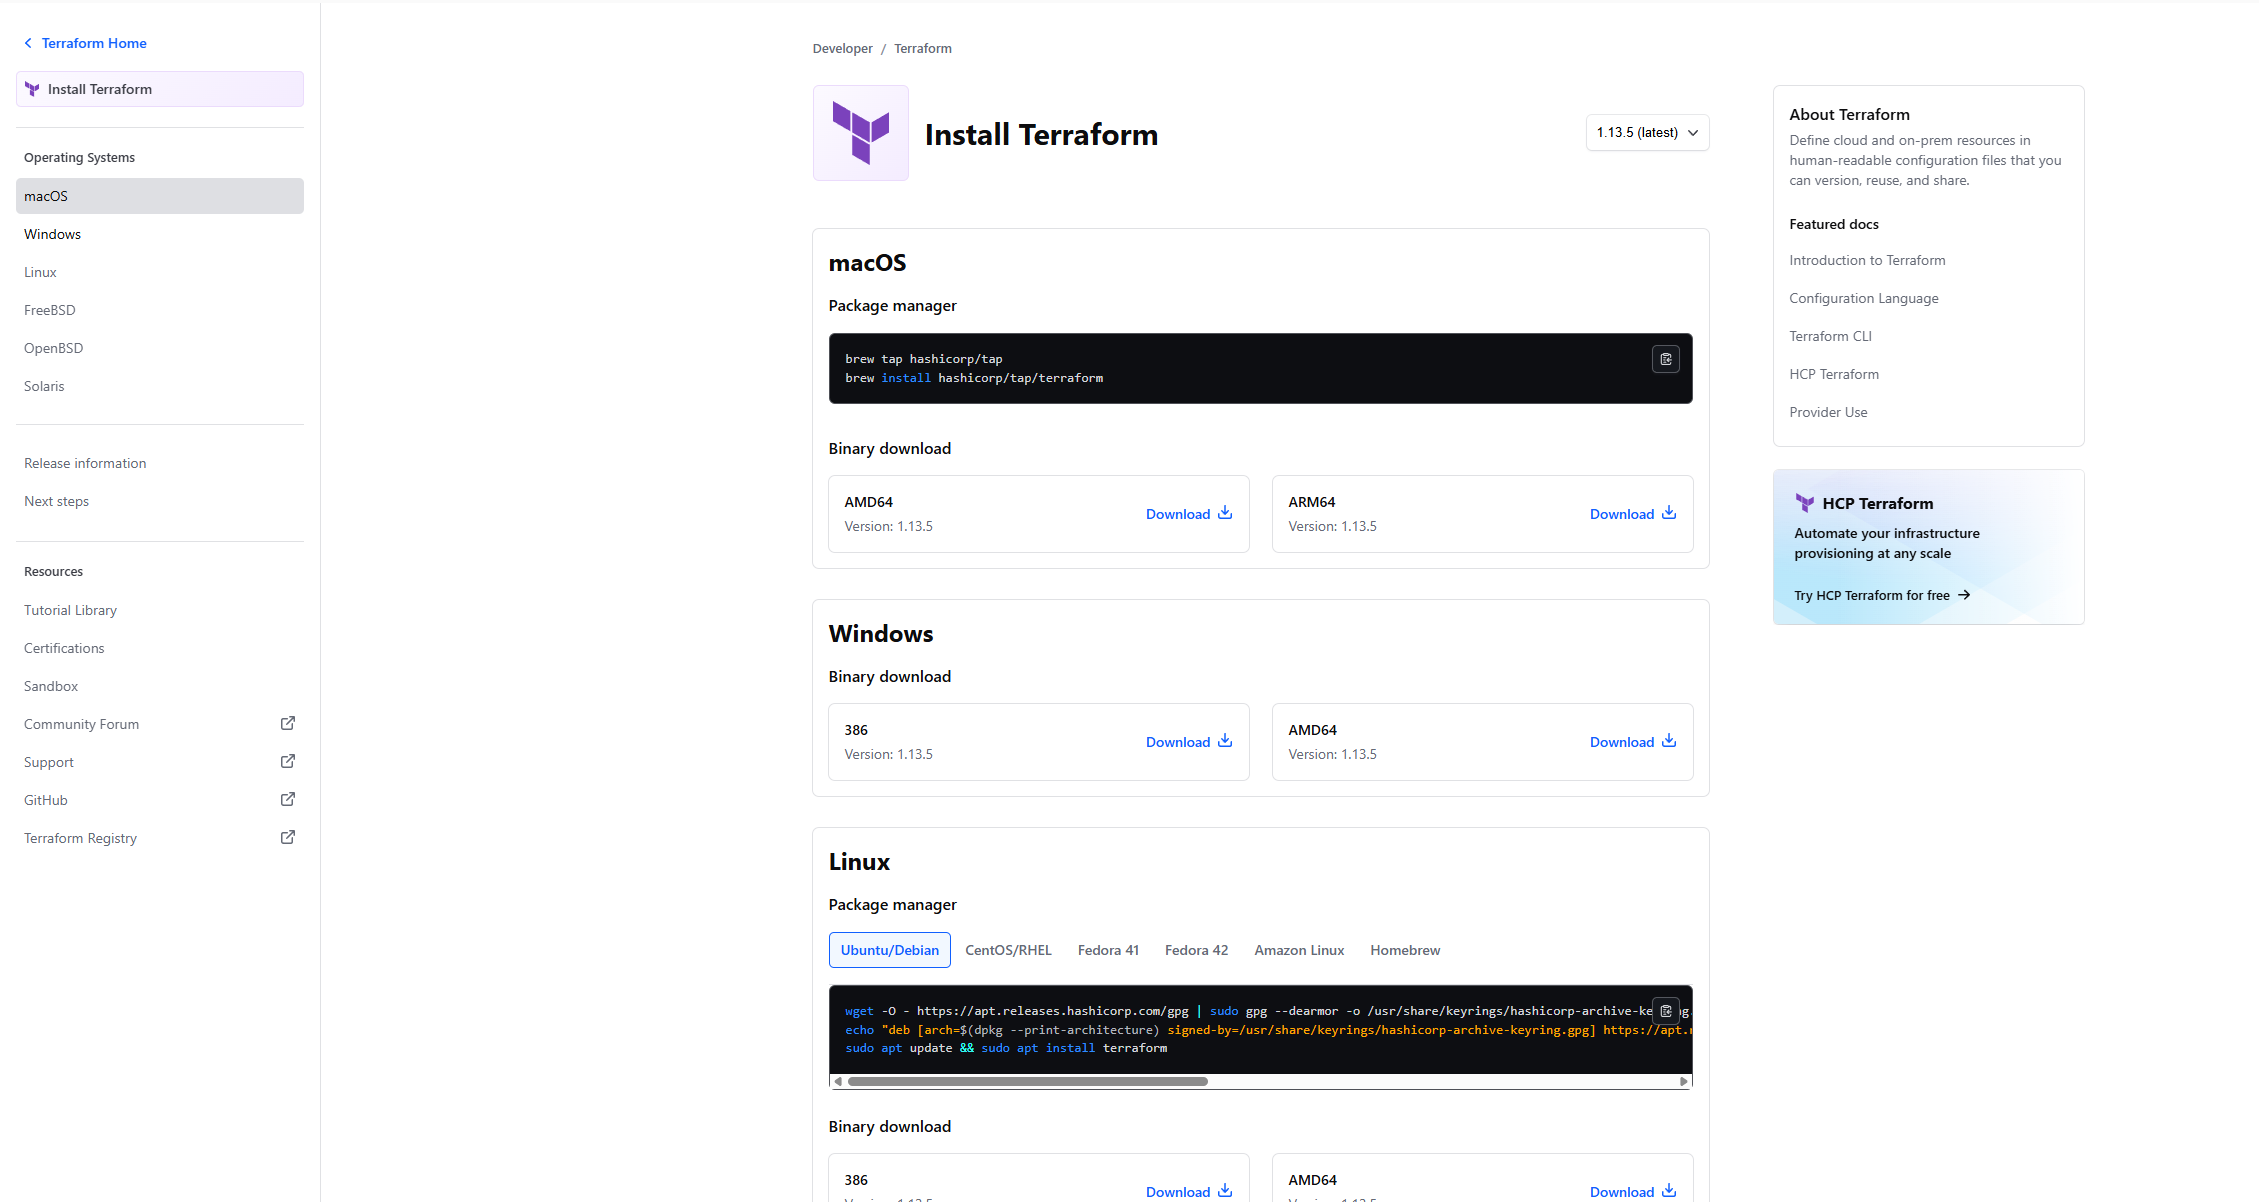

Если работает в VS Code для удобства можно скачать плагин terraform 

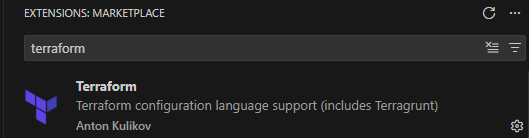

## Преимущества при работе с Terraform

- Скорость развертывания пользовательских виртуальных стендов (теннантов*)
- Моментальная проверка плана активации нового теннанта. 
- Удобное использование для создания демо-стендов под тестирование и отладку программного обеспечения. 

***теннанты** - логические сущности, использующие выделенные ресурсы в своих целях.



Манифесты Terraform — это файлы с расширением `.tf`, которые содержат описание ресурсов, их атрибутов и зависимостей. Для описания манифестов используется `HashiCorp Configuration Language` (HCL)

## Из чего состоит Terraform

1. `Providers`: провайдеры — это интерфейсы для взаимодействия с ресурсами, такими, как AWS, Google Cloud, Microsoft Azure и т. д.
2. `Resources`: ресурсы — это объекты, которые вы хотите создать, удалить или изменить. Например, виртуальная машина, балансировщик нагрузки, база данных.
3. `Variables`: переменные — это значения, которые можно передать в Terraform для конфигурирования вашей инфраструктуры.
4. `Data Sources`: источники данных — это инструменты, которые позволяют Terraform получать данные из внешних источников, таких как API, базы данных или другие службы.
5. `Outputs`: выводы — это результаты, которые Terraform выдает после выполнения конфигурации, например, IP‑адреса, идентификаторы ресурсов и т. д.

Дополнительные элементы:

1. Модули
2. Варианты окружения
3. Выражения


## Основные типы файлов

1. Файлы конфигурации (.tf файлы) — это основные файлы Terraform, которые содержат описание ресурсов, которые вы хотите создать или управлять.
2. Файлы переменных (.tfvars файлы) — это файлы, которые содержат значения переменных, использующихся в файлах конфигурации.
3. Файл состояния (.tfstate файл): это файл, который хранит текущее состояние вашей инфраструктуры.

## Лучшие практики

1. Не храните всю инфраструктуру в одном месте, разбейте её на части;
2. Изолируйте несвязанные компоненты друг от друга. Разделяйте логически свою инфраструктуру, сеть, сервисы, мониторинг и т. д.;
3. Не храните файл состояния локально;
4. Блокируйте файл состояния при работе;
5. Пишите код так, чтобы потом его можно было использовать в другом месте, используйте модули.
6. Пользуйтесь переменными — удобнее использовать переменные для управления конфигурацией инфраструктуры.
7. Пишите документацию, она всегда пригодится.

## Теперь немного более предметней:

Когда вы пишите код своей инфраструктуры, достаточно написать всё в одном файле, к примеру в файле `main.tf`:

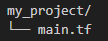

В нём будет всё, и объявление провайдеров, и ресурсы, и data sources, и outputs: 
(см. `my_project/main.tf`)

Всё бы ничего, если вы описали один ресурс, но их может быть два, а может и пару десятков. В таком файле будет уже сложнее разбираться и вносить изменения в инфраструктуру.
Хорошо, мы можем под каждый ресурс создавать отдельный файл, например `gitlab.tf`, `mongodb.tf`, `rebbitmq.tf` и т. д.:

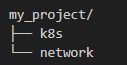

Но возникает ещё одна проблема — Terraform воспринимает все файлы в рабочем каталоге как один, а это значит, что и при запуске `plan` или `apply` он пойдёт перепроверять всю вашу инфраструктуру. Это долго и никому не нужно. Нет необходимости перепроверять ресурсы для кластера k8s, если изменения вносились в подсеть. Какой тогда выход? Всё просто, мы создадим отдельный рабочий каталог под каждый ресурс или связанную логически группу ресурсов:

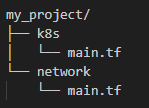

Далее, мы логически распределим код в отдельные файлы. Выглядит это следующим образом:

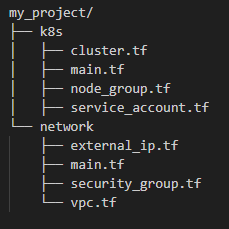

## Поднимаем кластер

Итак, теперь мы примерно понимаем, что к чему, и как нам организовать нашу конфигурацию. Давайте теперь перейдём к делу и начнём создание межрегионального кластера kubernetes с автоскейлингом worker-нод с помощью Terraform в Yandex Cloud. В этом кластере мы поднимем мониторинг посредством kube-prometheus-stack.

P.S. Еще раз обращу внимание, что о том как установить terraform можно поучитать [тут](https://developer.hashicorp.com/terraform/tutorials/aws-get-started/install-cli), а о Yandex.Cloud, который буду использовать в примере, [тут](https://yandex.cloud/ru/docs/cli/operations/install-cli).

Работать мы будем в отдельной директории `my_project2`

Давайте создадим эту дирректорию из терминала следующей командой: 

``` bash
mkdir ~/my_project2
```

Для того, чтобы создать кластер k8s нам потребуется сеть, подсеть и сервисный аккаунт. Поэтому, в соответствии с упомянутыми ранее рекомендациями, мы начнём создавать инфраструктуру с сети и её компонентов в отдельном рабочем каталоге network:

``` bash
mkdir ~/my_project2/network
cd ~/my_project2/network
```

Далее мы создадим файл `my_project2/network/main.tf` **# Вариант 1**, в нем пропишем провайдера и доступ к облаку

Перейдем к описанию сети и подсети, их мы опишем в файле `my_project2/network/vpc.tf` **# Вариант 1**

Это согласно инструкции Яндекса. Давайте на примере кода в `main.tf` и `vpc.tf` проведём ряд усовершенствований. Для начала вынесем имя сети и ещё пару параметров в переменные. Создадим файлы `terraform.tfvars` **# Вариант 1** и `variables.tf` **# Вариант 1**. Теперь наш рабочий каталог выглядит следующим образом:

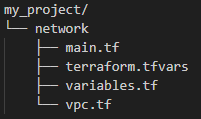

В файле `my_project2/network/variables.tf` укажем, что хотим создать четыре переменные 
Тут мы можем указать пояснение к переменной и указать тип данных. Также, визуально для эстетичности разграничим содержимое (см. указанный файл).

Далее, в файле `my_project2/network/terraform.tfvars` мы присвоим значение этим переменным (см. указанный файл).

И в конце концов перепишем в файлах `my_project2/network/main.tf` **# Вариант 2** и `my_project2/network/vpc.tf` **# Вариант 2** соответствующие параметры (см. указанные файлы)

Отлично, с переменными разобрались, теперь перейдём к циклу — зачем нам описывать три подсети, по сути одинаковых ресурса, если можно обойтись одним блоком кода, верно? Добавим в `my_project2/network/variables.tf` **# Вариант 2** описание переменной `subnets`, только здесь мы обозначим не один параметр, а их набор. У Terraform есть тип `map`, который нам отлично подходит под задачу.

Тут же, исключительно ради примера, делаю проверку на корректность указываемых значений с помощью блока `validation`, где в `condition` пишу условие, а в параметре `error_message` текст ошибки. Можно делать проверки на всё подряд, но это отдельная и трудоемкая задача.

Далее, в файле `my_project2/network/terraform.tfvars` **# Вариант 2** мы просто укажем значения.

Как можно заметить, я добавил ещё 3 подсети для воркер-нод, чтобы всё разграничить.

А теперь создадим файл `my_project2/network/local.tf` **# Вариант 1**.

Выражение перебирает входную переменную var.subnets и с помощью встроенной функции `flatten` сглаживает полученный вложенный список в единый одномерный список объектов. Каждый объект в результирующем списке имеет три атрибута: `name`, `zone` и `cidr`. При этом, оставляя значение для ключа `cidr` в списке, что очень важно. Ведь далее в ресурсе нам нужно указывать именно список.

Таким образом, мы можем переписать наш код в `my_project2/network/vpc.tf` **# Вариант 3** 

Здесь мы используем цикл `for_each`, в котором сопоставляем уникальный идентификатор с каждым элементом списка `local.subnet_array`. В данном случае, уникальным идентификатором является `name`.

Таким образом, сейчас для Terraform это выглядит как 6 ресурсов, и он создаст отдельные подсети с уникальным именем.

У нас есть 6 подсетей.

Что ещё. Давайте создадим статические IP-адреса, сколько бы их ни было. Действуем по тому же сценарию, в `my_project2/network/variables.tf` **# Вариант 3**  добавляем новую переменную `external_static_ips`

После этого в `my_project2/network/terraform.tfvars` **# Вариант 3**  добавляем значения. Сделаю один, но мы сразу закладываем возможность создания нескольких.

После этого создаём локальную переменную `external_ips_array` в `my_project2/network/locals.tf` **# Вариант 2**


Ну и, наконец, создадим файл `my_project2/network/static-ip.tf` **# Вариант 1**

Всё как и с подсетями.

Что ещё нам потребуется? Конечно же связность подсетей и безопасность, а значит пора заняться описанием `security group`.

Создадим файл `my_project2/network/security-group.tf` **# Вариант 1**, где опишем группы безопасности для мастеров и воркеров

Лично я считаю такую организацию групп безопасности более верной для кластера:

- internal, для связности мастеров и воркеров, здесь разрешено всё в рамках этой самой группы. 

- k8s_master исключительно под мастеров где разрешён доступ к 443 порту по переменной, которой мы должны передать вайтлист и служебное правило для балансировщиков.

- k8s_worker группа безопасности для воркеров, где мы разрешим вообще всё.

Создадим переменную `white_ips_for_master` для вайтлиста и пропишем значение для неё в `my_project2/network/variables.tf` **# Вариант 4**

и также запишем в `my_project2/network/terraform.tfvars` **# Вариант 4**

С network закончили, переносим сюда ключи от сервисного аккаунта и от бакета в файл `my_project2/network/storage.key` (его мы не создавали, т.к. не делали настройку яндекс облака как и файл `my_project2/network/key.json`). Рабочий каталог, после всех наших манипуляций, должен выглядеть следующим образом:

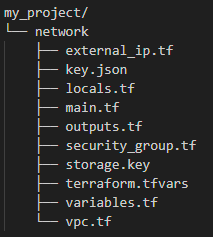

Можно запускать 
``` bash
terraform init
``` 
затем 
``` bash
terraform apply.
```

## Теперь переходим к каталогу k8s

``` bash
mkdir ~/my_project2/k8s
cd ~/my_project2/k8s
```

Всё по аналогии: создадим файлы `my_project2/k8s/main.tf`, `my_project2/k8s/variables.tf` и `my_project2/k8s/terraform.tfvars`, а также перенесём наши ключи. Кроме того, создадим ещё три конфигурационных файла `my_project2/k8s/cluster.tf`, `my_project2/k8s/node_group.tf` и `my_project2/k8s/service_account.tf`: (см. соответствующие файлы)

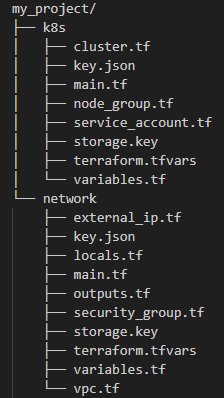

Переносим ресурсы для групп узлов в `my_project2/k8s/node_group.tf` **# Вариант 1**, описание кластера в `my_project2/k8s/cluster.tf` **# Вариант 1**, и всё, что относится к сервисным аккаунтам в `my_project2/k8s/service_account.tf` **# Вариант 1**, сюда же положим и ключ шифрования.

Так же, как и в `network`, создадим переменные в `my_project2/k8s/variables.tf` **# Вариант 1**

Присвоим им значения в `my_project2/k8s/terraform.tfvars` **# Вариант 1** и перепишем `my_project2/k8s/main.tf` **# Вариант 1**.

Не забываем сменить имя файла состояния в параметре `key`.

Итак, давайте переписывать. Начинаем с `my_project2/k8s/service_account.tf` **# Вариант 1**, у нас имя сервисного аккаунта было задано через `locals`, мы это переделаем. Нам нужно имя сервисного аккаунта и ключа шифрования задать через переменные, для этого создаём их `my_project2/k8s/variables.tf` **# Вариант 2**

И определяем `my_project2/k8s/terraform.tfvars` **# Вариант 2**

Переписываем `my_project2/k8s/service_account.tf` **# Вариант 2**

Что ж, вот мы и можем, наконец, приступить к оптимизации кода кластера. Давайте подставим наши значения в `cluster`, попутно прописав переменные для некоторых из них

`my_project2/k8s/variables.tf` **# Вариант 3**

Как вы можете видеть, у двух переменных, а именно `master_public_ip` и `network_policy_provider`, уже задано дефолтное значение. Нам нужно в `my_project1/k8s/terraform.tfvars` **# Вариант 3** указать остальные

Вот мы и дошли до важнейшего момента - нам необходимо указать `id` сети, но её мы поднимали другим манифестом Terraform'а, а значит, из этого манифеста Terraform не может увидеть созданные там ресурсы. как же быть?

Для того, чтобы получить какие-либо данные извне, есть `data sources`. С помощью `data` мы можем указать терраформ источник, откуда ему следует взять данные. 

Создадим файл `my_project2/k8s/data.tf` **# Вариант 1**

Источник данных указывается очень просто:  `data`, и прописываем откуда брать данные, а нужна нам сеть с именем `mynet`.

Теперь нам достаточно сослаться на этот источник в описании ресурса, обязательно указав что именно нам нужно оттуда забрать - `data.yandex_vpc_network.mynet.id`:

```bash
resource "yandex_kubernetes_cluster" "k8s-regional" {  
network_id = data.yandex_vpc_network.mynet.id
[...]
}
```

Можем оставить так, но что, если имя сети поменяется? Переписали мы конфигурацию сети, нам же придётся и в каталоге `k8s` в `my_project2/k8s/data.tf` поменять параметр, а ведь мы переписываем код для того, чтобы не лазить больше в конфигурационные файлы. Мы можем вынести этот параметр в переменные и менять его там - скажете вы. А что, если вообще не заморачиваться над тем, как назван ресурс? Что, если мы укажем `id` сети так, что нам нигде не придётся ничего переписывать при любых изменениях в манифесте network? Для этого нужно ответить на один вопрос - а где ещё хранятся данные о созданных ресурсах любого манифеста? Верно, в файле состояния. Вот мы и укажем Terraform'у сходить и прочитать другой `tfstate` файл.

Создадим другой источник данных и в нем укажем путь и доступы к чужому файлу состояния в `my_project2/k8s/data.tf` **# Вариант 2**. 

Как видите, здесь используются переменные, давайте их создадим в `my_project2/k8s/variables.tf` **# Вариант 4** и `my_project2/k8s/terraform.tfvars` **# Вариант 4**. И присвоим значения - их мы возьмём из `main.tf` в каталоге `network`. Расположил я их после переменных для `main`.

Теперь мы можем читать другой файл состояния и считывать оттуда значения, однако, их там пока нет. Для того, чтобы они появились, нам нужно вернуться в каталог network и оформить outputs. Итак, создаём `my_project2/network/outputs.tf` **Вариант 1** и описываем то, что хотим вывести

А нужно нам `id` сети. Вот и всё. Обязательно запустите `terraform apply`, чтобы данные записались в файл состояния.

Теперь, для того, чтобы нам сослаться на какой-либо ресурс из `network`, потребуется постоянно указывать конструкцию `data.terraform_remote_state.network.outputs`. и имя того output’а который нам нужен.

Например:

```bash
resource "yandex_kubernetes_cluster" "k8s-regional" {  
network_id = data.terraform_remote_state.network.outputs.network_id
[...]
}
```

Давайте используем `my_project2/k8s/locals.tf` **# Вариант 1**, чтобы упростить себе жизнь. Итак, создаём файл locals.tf тут мы создадим переменную `locals`

Теперь можем всегда указывать просто:

```bash
resource "yandex_kubernetes_cluster" "k8s-regional" {  
network_id = local.network_output.network_id
[...]
}
```

Думаю так гораздо удобнее.

Давайте для групп безопасности тоже выведем `id` в `my_project2/network/outputs.tf` **# Вариант 2**, т.к. они нам также понадобятся.

Но также нам нужны `зоны` и `id` подсетей. Здесь уже сложнее, ведь мы не можем просто указать эти значения, так же, как и для других, поскольку подсети у нас создаются циклом в `network` и писать `output` под каждую подсеть мы не можем. 

Для нашей задачи мы действительно используем output, но для этого напишем небольшое условие в `my_project2/network/outputs.tf` **# Вариант 3**


Как вы помните, мы создали 6 подсетей, три под мастеров и три под воркеров, вот я и хочу получить их id и zone разными output»ами: первый — под наши требования для кластера, а второй — заранее сделаем для воркеров.

Здесь мы фильтруем значение переменной subnets, чтобы бралась информация только по необходимым подсетям(в данном случае для мастеров). Далее с помощью функции zipmap мы создаём список, где присваиваем ключам subnet_id и zone соответствующие атрибуты из переменной, и так для каждой подсети в k8s_masters.

Аналогично и для подсетей в k8s_workers.

Перезапускаем terraform apply.

Окей, теперь переписываем конфигурацию на переменные, а ID групп безопасности указываем две, internal и k8s_master из output'ов предыдущего манифеста в `my_project2/k8s/cluster.tf` **# Вариант 2**

Для того, чтобы указать подсети и зоны, мы используем dynamic блок с циклом for_each, указываем, откуда будем брать значения (а берем мы их из нашего нового output»a). Далее мы описываем content, и сюда пишем те параметры, которые нужны этому блоку, а нужны зона и ID, теперь указываем откуда брать значения, а их мы берем из того цикла, который мы передали, т. е. location.value и указываем какой элемент нужен.

Запускаем terraform init и terraform apply в каталоге k8s.

Ну вот, у нас получилось поднять инфраструктуру с помощью двух разных манифестов Terraform. Бежим в Яндекс и проверяем — кластер на месте. Нам осталось решить, как описать группы узлов. Они у нас так же, как и подсети до этого, указаны тремя ресурсами. Давайте исправлять. Как вы наверное уже догадались, делать мы это будем через тот же for_each. Но сначала, создадим переменную `my_project2/k8s/variables.tf` **# Вариант 5**

И присвоим значение этой переменной в `my_project2/k8s/terraform.tfvars` **# Вариант 4**

Тут мы указываем всё то, что хотим видеть в параметрах ресурса, главное потом это правильно присвоить. Как вы могли заметить, блоки отличаются, а именно для node‑group‑a указан `auto_scale`, а для остальных групп `fixed_scale`. Таким образом, я хочу добавить возможность менять тип групп через переменные.

Также, в yandex_kubernetes_node_group нам потребуется указать id подсетей. Вспоминаем о нашем ранее созданном output»е — k8s_workers_subnet_info, но там передаётся не только id, но и зона. В чем проблема? — спросите вы. Ведь можно переписать output, чтобы он выдавал только id. Но нет, в таком случае у нас пропадёт привязка к зоне, ведь мы просто получим набор id, и понять какой из них принадлежит определённой зоне не получится. Да, они у нас сейчас по порядку, первый id будет относится к зоне ru‑cenral1-a, второй — к b и третий — к c. Но это мы в манифесте network нашей переменной так значения по порядку указали, а вот если их поменять местами, получим путаницу с таким подходом, и поднимется у нас, к примеру, группа с именем node‑group‑a в зоне b. Поэтому output мы не трогаем, а сделаем преобразование данных через locals в `my_project2/k8s/locals.tf` **# Вариант 2**

Создаём переменную `worker_subnet_list`, тут мы создадим список, где каждой зоне присвоится id.

Возвращаемся к нашему ресурсу в файл `my_project2/k8s/node_group.tf` **# Вариант 2**

- Конечно же, меняем имя ресурса в Terraform'е.

- Объявляем, что хотим использовать for_each и указываем откуда циклу брать значения (а лежат они в переменной node_groups).

- name, берет значение из each.key, это у нас имя объекта: node‑group‑a, node‑group‑b и node‑group‑c.

- Далее присваиваем значения остальным параметрам, но делаем мы это по условию, для этого используем функция lookup, синтаксис у неё очень прост, мы указываем где искать, что искать, и что присвоить если ничего не нашла (значение по умолчанию).

- subnet_ids ставим источник local.worker_subnet_list, указываем что брать, а забирать мы будем id той зоны, которая указана в переменной node_groups, поэтому ставим each.value[«zone»]. Дефолтное значение убираем, т.к. сюда мы по умолчанию ничего не сможем поставить.

- security_group_ids — группы безопасности мы указываем без всяких условий, просто указываем нужные output»ы.

- scale_policy — как я уже говорил, нужна возможность выбора, либо фиксированная группа узлов, либо с автоскейлингом — для этого добавляем два соответствующих dynamic блока, в них описываем цикл, но, просто указать источник значений не получится, у нас в переменной вложенный список для этих блоков, чтобы вытащить необходимые значения, нужно этот список вытащить из другого, для этого воспользуемся функцией flatten, которая выравнивает вложенные списки. А далее можем использовать lookup — отличие лишь в том, что для блока fixed_scale на месте дефолтного значения мы ставим условие, которое проверяет наличие параметра auto_scale и если он есть, оставляет этот блок fixed_scale без значения, а если нет, то выставляет один фиксированный узел.

- В content для этих блоков указываем использовать значения из соответствующего источника: для auto_scale — auto_scale.value.что_берем, для fixed_scale — fixed_scale.value.size

- allocation policy: без всяких lookup'ов ссылаемся на нужное значение.

Получившаяся конфигурация должна поднимать для нас региональный кластер Kubernetes, с автоскейлингом нод в зоне ru‑central1-a, а в остальных зонах с 1 фиксированный нодой.

Однако, в процессе подготовки тестового стенда я столкнулся с проблемой, что инфраструктура поднималась и работала с этим кодом, а уже на следующий день — нет. Все необходимые узлы создавались, но не имели связи с мастерами. После проверки, я понял, что правила для группы безопасности не отрабатывают так, как это задумано. Пришлось переписать группу internal в `my_project/network/security-group.tf` **# Вариант 2**

Поясню свою мысль. Правило, где мы выставляем `predefined_target = «self_security_group»`, должно разрешать всё в рамках этой самой группы, т. е. хосты, к которым привязана группа `internal` (а в нашем случае это все мастеры и воркеры), должны свободно общаться друг с другом. Но этого не происходит — по информации от техподдержки, они перерабатывают механизм работы этого правила, и пока оно может «работать неожидаемым образом, когда эндпоинты находятся в разных зонах». Поэтому, мне пришлось добавить другое, которое открывает доступ всем узлам, находящимся в перечисленных в ней подсетях.

## Как работает правило: 

1. Нам нужны cidr наших подсетей, они у нас в переменной subnets. Однако, нам не нужно собирать этот параметр со всех подсетей, мы же можем прописать создание и других, не только для кластера и воркеров, как сейчас, — у нас могут появиться другие подсети, и мы не можем позволить трафику с других хостов, которые не относятся к кластеру, ходить к нему. Поэтому отфильтруем только то, что относится к кластеру, — это мастеры и воркеры:

```bash
[(var.subnets["k8s_masters"], var.subnets["k8s_workers"])]
```

2. Но, таким образом, мы получили два списка. Не проблема, вызовем функцию concat, которая объединяет несколько списков в один: 

```bash
concat(var.subnets["k8s_masters"], var.subnets["k8s_workers"]) 
```

3. Теперь, нужно вытащить только cidr, а у нас в переменной помимо этого ключа ещё name и zone, поэтому напишем условие, что в список мы собираем только значения ключа cidr:
```bash
[for v in concat(var.subnets["k8s_masters"], var.subnets["k8s_workers"]) : v.cidr]
```

4. Мы получили нужные параметры, но, cidr у нас представлен в переменной, как вложенный список, с помощью flatten мы выравниваем этот список:
```bash
flatten([for v in concat(var.subnets["k8s_masters"], var.subnets["k8s_workers"]) : v.cidr])
```
Вот теперь, можем запускаем `terraform apply` и любуемся на нашу инфраструктуру.

Если есть необходимость в настройке дополнительных параметров, как доступ по ssh к воркер‑нодам, вы это сможете сделать уже самостоятельно, почитав документацию.

Для того, чтобы получить какие-либо данные извне, есть data sources. С помощью data мы можем указать терраформ источник, откуда ему следует взять данные. 
Создадим файл `data.tf`


Вот теперь, можем запускаем 
``` bash
terraform apply
```